In [2]:
import httplib2
import oauth2
import urllib3
import types
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from gender_detector import GenderDetector 
import psycopg2, psycopg2.extras
from causalinference import CausalModel
from causalinference.utils import random_data
import httplib
import base64
import json # For Microsoft Face API
import urllib as urllib # For Microsoft Face API
import time 
import csv
import datetime 
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Initialize arrays for Causal Analysis 
user_count = 1
bill_rate_array = []
gender_array = []
all_covariates_array = []

# Read data from csv files and reformat
all_data_file_name = './csv_files/2017_12_12_upwork_analysis_unitedstates_allskills.csv' # Filename for all data
gender_data_file_name = './csv_files/2017_12_12_upwork_face_data_unitedstates_allskills.csv' # Filename for gender data
df = pd.read_csv(all_data_file_name)
df_gender = pd.read_csv(gender_data_file_name)

# Merge the files, then remove rows with an error, no gender identified, or ambiguous education
merged = df.merge(df_gender, on='user_count')
merged = merged[merged.bill_rate != 'error']
merged = merged[merged.gender != 'error']
merged = merged[merged.education != 'None']
merged = merged[merged.work_experience != 'error']
merged = merged[merged.jobs_completed != 'error']
merged = merged[merged.job_category != 'none']

# Format bill rate and work experience properly 
merged['bill_rate'] = merged.bill_rate.astype('float')
merged['work_experience'] = merged.work_experience.astype('float')

# Calculate mean and standard deviation
sd = np.std(merged['bill_rate'])
mean = np.mean(merged['bill_rate'])
print("Bill rate average: {0}".format(mean))
print("Bill rate standard deviation: {0}".format(sd))

merged['bill_rate'] = merged.bill_rate.astype('float')
merged['work_experience'] = merged.work_experience.astype('float')
female_count = 0
male_count = 0

# Check that arrays contain complete data
print "Bill rate array length: {0}".format(len(bill_rate_array))
print "Gender array length: {0}".format(len(gender_array))
print "Covariate array length: {0}".format(len(all_covariates_array))
print "Female count: {0}, Male count: {1}".format(female_count, male_count)

merged['outlier'] = merged['bill_rate'] >= mean + 2*sd

merged.groupby(['outlier', 'gender']).size()

/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Bill rate average: 39.8293404168
Bill rate standard deviation: 37.9426751272
Bill rate array length: 0
Gender array length: 0
Covariate array length: 0
Female count: 0, Male count: 0


outlier  gender
False    female    14637
         male      16025
True     female      442
         male        613
dtype: int64

gender     female      male
outlier                    
False    0.477366  0.522634
True     0.418957  0.581043


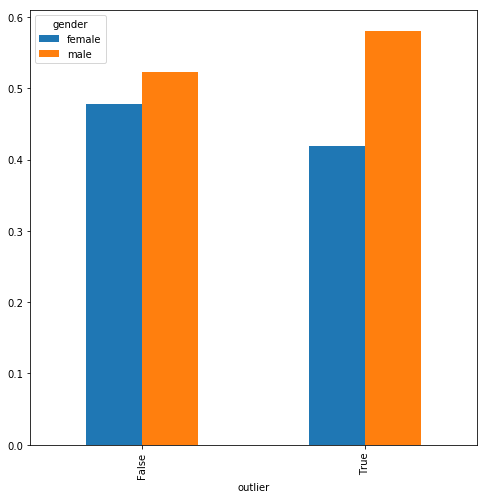

In [11]:
gender_table = pd.crosstab(merged['outlier'], merged['gender'], normalize='index')
print gender_table
gender_table.plot(kind="bar", figsize=(8,8))

education  Associate  Bachelor  Doctorate  High School    Master  Professional
outlier                                                                       
False       0.093438  0.613235   0.023384     0.033331  0.220794      0.015818
True        0.037915  0.525118   0.061611     0.018957  0.299526      0.056872


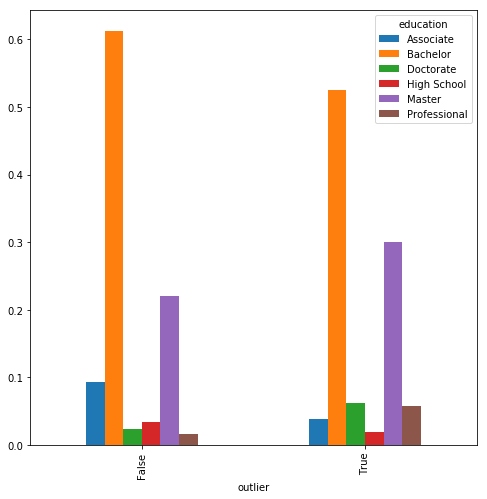

In [16]:
education_table = pd.crosstab(merged['outlier'], merged['education'], normalize='index')
print education_table
education_table.plot(kind="bar", figsize=(8,8))

age_range_id         0         1         2         3         4         5  \
outlier                                                                    
False         0.020286  0.110821  0.506262  0.262116  0.072696  0.017187   
True          0.011374  0.083412  0.466351  0.320379  0.085308  0.017062   

age_range_id         6  
outlier                 
False         0.010632  
True          0.016114  


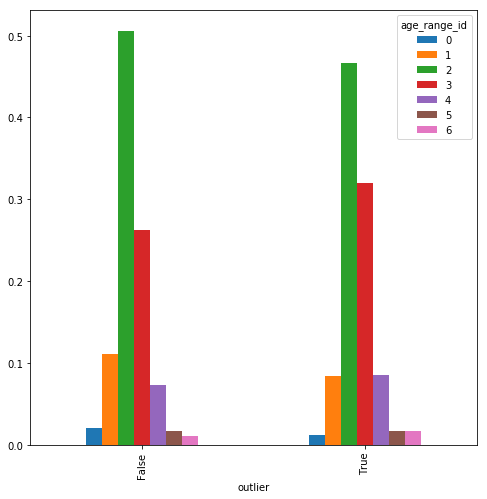

In [18]:
age_table = pd.crosstab(merged['outlier'], merged['age_range_id'], normalize='index')
print age_table
age_table.plot(kind="bar", figsize=(8,8))

job_category
Accounting & Consulting       186
Admin Support                  17
Customer Service                7
Data Science & Analytics       50
Design & Creative             188
Engineering & Architecture     47
IT & Networking                74
Legal                          38
Sales & Marketing             152
Translation                    12
Web, Mobile & Software Dev    171
Writing                       113
dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f74ddf8db50>], dtype=object)

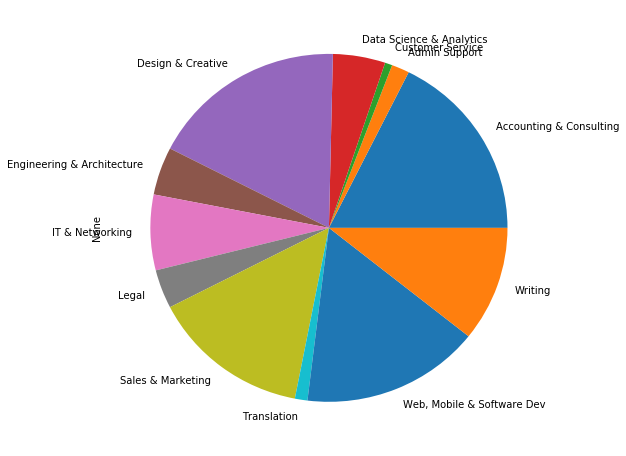

In [28]:
jobs_outliers = merged[merged['outlier'] == True]
jobs_outliers = jobs_outliers.groupby('job_category').size()
print jobs_outliers
jobs_outliers.plot(kind='pie', subplots=True, figsize=(8, 8))

job_category
Accounting & Consulting       1630
Admin Support                 3747
Customer Service               720
Data Science & Analytics      1252
Design & Creative             7012
Engineering & Architecture     975
IT & Networking                768
Legal                          184
Sales & Marketing             2229
Translation                   1054
Web, Mobile & Software Dev    4433
Writing                       6658
dtype: int64


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f74de2e4410>], dtype=object)

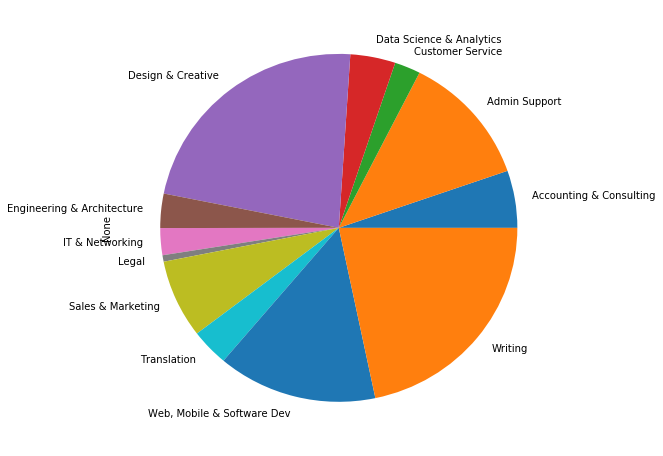

In [29]:
jobs_non_outliers = merged[merged['outlier'] == False]
jobs_non_outliers = jobs_non_outliers.groupby('job_category').size()
print jobs_non_outliers
jobs_non_outliers.plot(kind='pie', subplots=True, figsize=(8, 8))

## Is there a gender pay gap for outliers in the dataset?
No

In [31]:
model = ols("bill_rate ~ gender", merged[merged['outlier'] == True]).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(model.summary())
print anova_table

                            OLS Regression Results                            
Dep. Variable:              bill_rate   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7182
Date:                Tue, 16 Jan 2018   Prob (F-statistic):              0.397
Time:                        16:47:37   Log-Likelihood:                -6424.8
No. Observations:                1055   AIC:                         1.285e+04
Df Residuals:                    1053   BIC:                         1.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        176.2845      5.085     34.

## Are outliers in the dataset more likely to be men or women? 

In [45]:
from scipy.stats import chisquare

# Create an array of counts of men and women in each outlier/non-outlier group
gender_table = pd.crosstab(merged['outlier'], merged['gender'])
print gender_table

expected_gender_frequencies = [48, 52] # Total frequency = 30,662, elements in array are percentages of total frequency
observed_gender_frequencies = [42, 58] # Total frequency = 1,055, elements in array are percentages of total frequency

chi_square_gender = chisquare(observed_gender_frequencies, f_exp = expected_gender_frequencies)

print chi_square_gender

gender   female   male
outlier               
False     14637  16025
True        442    613
Power_divergenceResult(statistic=1.4423076923076923, pvalue=0.22976627046113451)


## Are outliers in the dataset more likely to be in certain job categories?

In [7]:
from scipy.stats import chisquare

gender_table = pd.crosstab(merged['outlier'], merged['job_category'])
print gender_table

non_outlier_values = [1630, 3747, 720, 1252, 7012, 975, 768, 184, 2229, 1054, 4433, 6658] 
outlier_values = [186, 17, 7, 50, 188, 47, 75, 38, 152, 12, 171, 113] 

total_non_outliers = np.sum(non_outlier_values)
total_outliers = np.sum(outlier_values)

expected_values = []
observed_values = []

for value in non_outlier_values:
    expected_values.append(float(value)/float(total_non_outliers)*100)

for value in outlier_values:
    observed_values.append(float(value)/float(total_outliers)*100)

print expected_values
print observed_values

chi_square_jobs = chisquare(observed_values, f_exp = expected_values)                           

print chi_square_jobs

job_category  Accounting & Consulting  Admin Support  Customer Service  \
outlier                                                                  
False                            1630           3747               720   
True                              186             17                 7   

job_category  Data Science & Analytics  Design & Creative  \
outlier                                                     
False                             1252               7012   
True                                50                188   

job_category  Engineering & Architecture  IT & Networking  Legal  \
outlier                                                            
False                                975              768    184   
True                                  47               74     38   

job_category  Sales & Marketing  Translation  Web, Mobile & Software Dev  \
outlier                                                                    
False                      2229  

In [10]:
from scipy.stats import chisquare

edu_table = pd.crosstab(merged['outlier'], merged['education'])
print edu_table

non_outlier_values = [2865, 18803, 717, 1022, 6770, 485] 
outlier_values = [40, 554, 65, 20, 316, 60] 

total_non_outliers = np.sum(non_outlier_values)
total_outliers = np.sum(outlier_values)

expected_values = []
observed_values = []

for value in non_outlier_values:
    expected_values.append(float(value)/float(total_non_outliers)*100)

for value in outlier_values:
    observed_values.append(float(value)/float(total_outliers)*100)

print expected_values
print observed_values

chi_square_edu = chisquare(observed_values, f_exp = expected_values)                           

print chi_square_edu

education  Associate  Bachelor  Doctorate  High School  Master  Professional
outlier                                                                     
False           2865     18803        717         1022    6770           485
True              40       554         65           20     316            60
[9.343813188963537, 61.323462265996994, 2.3383993216359014, 3.3331159089426654, 22.07944687235014, 1.5817624421107561]
[3.7914691943127963, 52.51184834123222, 6.161137440758294, 1.8957345971563981, 29.95260663507109, 5.687203791469194]
Power_divergenceResult(statistic=24.897694658384417, pvalue=0.00014581603968831137)


In [12]:
from scipy.stats import chisquare

edu_table = pd.crosstab(merged['outlier'], merged['age_range_id'])
print edu_table

non_outlier_values = [622, 3398, 15523, 8037, 2229, 527, 326] 
outlier_values = [12, 88, 492, 338, 90, 18, 17] 

total_non_outliers = np.sum(non_outlier_values)
total_outliers = np.sum(outlier_values)

expected_values = []
observed_values = []

for value in non_outlier_values:
    expected_values.append(float(value)/float(total_non_outliers)*100)

for value in outlier_values:
    observed_values.append(float(value)/float(total_outliers)*100)

print expected_values
print observed_values

chi_square_edu = chisquare(observed_values, f_exp = expected_values)                           

print chi_square_edu

age_range_id    0     1      2     3     4    5    6
outlier                                             
False         622  3398  15523  8037  2229  527  326
True           12    88    492   338    90   18   17
[2.0285695649337945, 11.082121192355359, 50.62618224512426, 26.211597416998238, 7.269584501989433, 1.7187398082316876, 1.06320527036723]
[1.1374407582938388, 8.341232227488153, 46.63507109004739, 32.03791469194313, 8.530805687203792, 1.7061611374407581, 1.6113744075829384]
Power_divergenceResult(statistic=3.1805989072577785, pvalue=0.78586231011324936)
